## Analysis : Entropy analysis

This notebook contains all code used to generate Supplementary Figure 13. It uses the _stereoscope_ cell type mappings to the entropy (Shannon entropy) of each spot based on the cell type distribution obtained from the _steroscope_ mapping.

We stratify the spots from each sample by cluster identity and show how the joint scores are distributed within these subsets by using a variant of the violin plot similar to [bean plots](https://cran.r-project.org/web/packages/beanplot/vignettes/beanplot.pdf). Our plots differ from the standard violin plot also showing each individual data point as a black horizontal line. We also indicate the median by a red cricle with a black edge. For this we provide our own function `bean_plot` (found in _utils_) that utilize the already exisiting _violinplot_ function in the plotting suite. 

## Load modules

In [18]:
from collections import Counter
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import os
import os.path as osp

from utils import bean_plot
from spw_enr import get_enr

from typing import Tuple,List,Dict,Callable,Union,Any,Optional


from matplotlib.colors import LinearSegmentedColormap as CMAP

## Define Functions and variables

In [24]:
def read_file(f : str):
    return pd.read_csv(f,
                    sep = "\t",
                    header = 0,
                    index_col = 0,
                   )


In [84]:
def entropy(data : pd.DataFrame,
            )->np.ndarray:

    # spots as rows
    # features as columns

    if isinstance(data,pd.DataFrame):
        x = data.values.astype(float)
    else:
        x = data.astype(float)

    sms = x.sum(axis = 1, keepdims = True)
    nx = np.divide(x,sms, where = sms > 0)
    nx[nx == 0] = np.nan
    nl = np.log2(nx)
    ex = nl * nx
    ex[np.isnan(ex)] = 0

    return -ex.sum(axis = 1)


In [73]:
def spot_wise_assesment(data_dir : List[str],
                        meta_dir : List[str],
                        funs : Dict[str,Callable],
                        funs_args : Dict[str,Dict[str,Any]],
                        base_fun : Optional[Callable] = None,
                        label_col : str = "label",
                        )->List[Dict[str,Dict[str,np.ndarray]]]:


    sample_files = os.listdir(data_dir)
    sample_files.sort()
    sample_files = sample_files
    meta_files = os.listdir(meta_dir)
    meta_files.sort()

    assert len(funs) == len(funs_args),\
        "functions and arg lists must be of"\
        " same length."

    sampleSE = {k:{} for k in funs.keys()}

    for sample in sample_files:

        if base_fun is None:
            base = ".".join(sample.split(".")[0:-(2 if ".gz" in sample else 1)])
        else:
            base = base_fun(sample)

        for k in funs.keys():
            sampleSE[k][base[0]] = dict()

        print("Reading Sample >> {}".format(sample))

        cnt_pth = osp.join(data_dir,
                           sample)

        main = read_file(cnt_pth)


        if meta_dir is not None:
            mta_pth = list(filter( lambda x : base in x,meta_files))[0]

            mta_pth = osp.join(meta_dir,mta_pth)


            meta = read_file(mta_pth)

            meta.index = pd.Index([str(x) + "x" + str(y)\
                                for x,y in zip(meta["x"],meta["y"])])

            for (fun_name,fun) in funs.items():
                for label in np.unique(meta[label_col]):
                    sel = meta.index[meta[label_col].values == label]
                    sub_main = main.loc[sel,:].values.astype(float)

                    score = fun(sub_main,
                                **funs_args[fun_name])

                    cluster_name = "{}".format(label)
                    sampleSEpat = sampleSE[fun_name][base[0]]

                    if cluster_name in sampleSEpat.keys():
                        sampleSEpat = np.append(sampleSEpat[cluster_name],score)
                    else:
                        sampleSEpat[cluster_name] = score
        else:
            for (fun_name,fun) in funs.items():
                score = fun(main,**funs_args[fun_name])
                sampleSE[fun_name][base[0]] = score

    return sampleSE


def plot_spot_wise_res(results : Dict[str,Dict[str,np.ndarray]],
                       n_cols : int = 4,
                       box_size : float = 1,
                       row_height : float = 3,
                       cmap : CMAP = plt.cm.Set1,
                       swarm_plot : bool = True,
                       **kwargs,
                       )->Tuple[plt.Figure,plt.Axes]:


    n_rows = int(np.ceil(len(results) / n_cols))

    n_clusters = np.array([ len(y.values()) for y in results.values()])
    n_clusters = np.array_split(n_clusters,n_cols)
    n_max_clusters = np.max([sum(x) for x in n_clusters])
    width = n_max_clusters * box_size
    height = n_rows * row_height

    figsize = (width,height)

    fig,ax = plt.subplots(n_rows,
                          n_cols,
                          figsize = figsize,
                          sharey = kwargs.get("share_y",True))
    ax = ax.flatten()

    for k,(patient,scores) in enumerate(results.items()):
        vns = bean_plot(ax[k],
                        vals = list(scores.values()),
                        cmap = plt.cm.Set1,
                        )


        ax[k].set_xticklabels(list(scores.keys()),rotation = 90)
        ax[k].set_title(kwargs.get("title","Patient {}".format(patient)))
        ax[k].set_ylabel(kwargs.get("ylabel","spot-wise value"))
        ax[k].set_xlabel(kwargs.get("xlabel","cluster"))

        for side in ["top","right"]:
            ax[k].spines[side].set_visible(False)

    fig.tight_layout()

    return (fig,ax)


In [85]:
# current working directory is 
# assumed to be "her2st/scripts"

# directory for proportion values
PROP_DIR = "../res/ST-deconv/props/major"
# directory for cluster labels
CLU_DIR = "../res/ST-cluster/lbl/"

# directroy to save results to
RES_DIR = "/tmp/entropy"
if not osp.exists(RES_DIR):
    import os
    os.mkdir(RES_DIR)

# save figures
save = True

Reading Sample >> A1-proportion.tsv
Reading Sample >> A2-proportion.tsv
Reading Sample >> A3-proportion.tsv
Reading Sample >> A4-proportion.tsv
Reading Sample >> A5-proportion.tsv
Reading Sample >> A6-proportion.tsv
Reading Sample >> B1-proportion.tsv
Reading Sample >> B2-proportion.tsv
Reading Sample >> B3-proportion.tsv
Reading Sample >> B4-proportion.tsv
Reading Sample >> B5-proportion.tsv
Reading Sample >> B6-proportion.tsv
Reading Sample >> C1-proportion.tsv
Reading Sample >> C2-proportion.tsv
Reading Sample >> C3-proportion.tsv
Reading Sample >> C4-proportion.tsv
Reading Sample >> C5-proportion.tsv
Reading Sample >> C6-proportion.tsv
Reading Sample >> D1-proportion.tsv
Reading Sample >> D2-proportion.tsv
Reading Sample >> D3-proportion.tsv
Reading Sample >> D4-proportion.tsv
Reading Sample >> D5-proportion.tsv
Reading Sample >> D6-proportion.tsv
Reading Sample >> E1-proportion.tsv
Reading Sample >> E2-proportion.tsv
Reading Sample >> E3-proportion.tsv
Reading Sample >> F1-proport

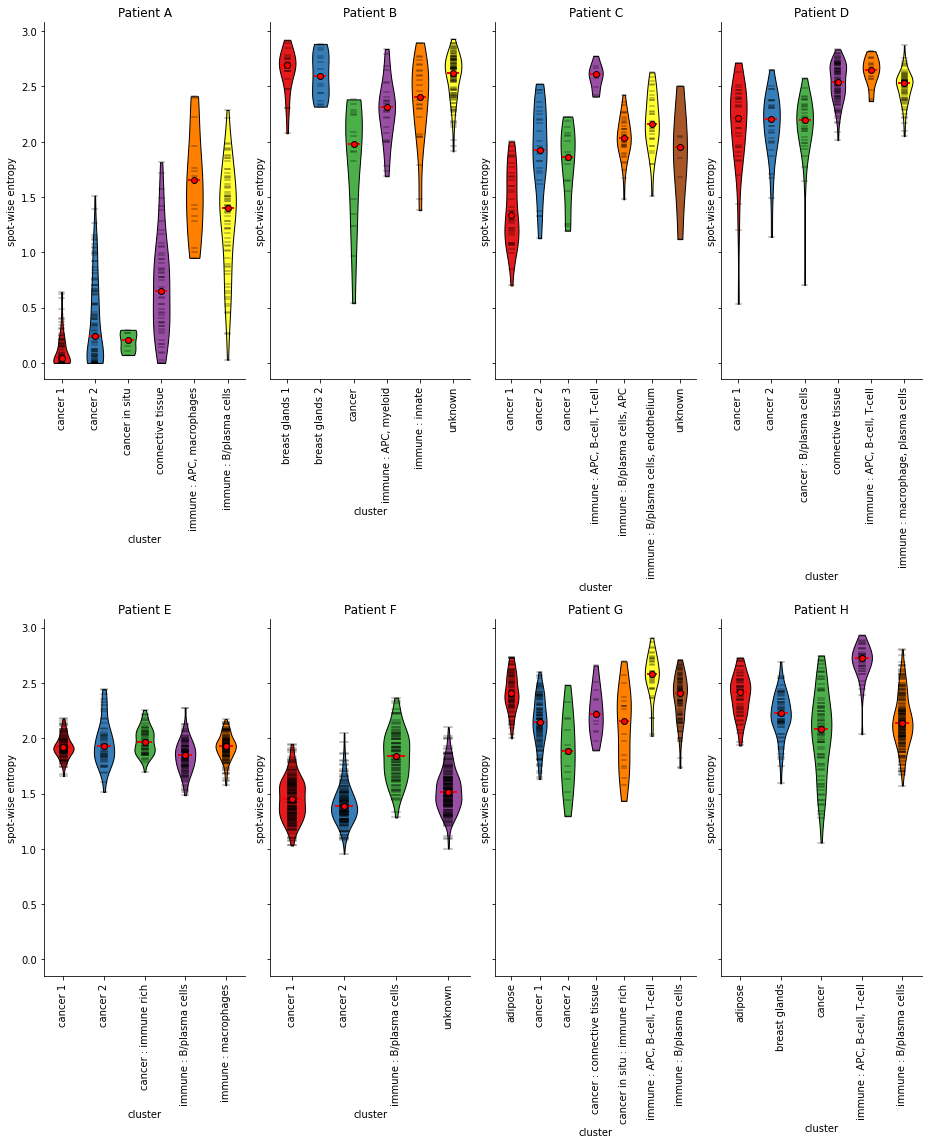

In [86]:
funs = dict(entropy = entropy)
funs_args = dict(entropy=dict())
base_fun = lambda x : x.split("-")[0]

res = spot_wise_assesment(data_dir = PROP_DIR,
                          meta_dir = CLU_DIR,
                          funs = funs,
                          funs_args = funs_args,
                          base_fun = base_fun,
                          label_col = "label_annot",
                          )


fig,ax = plot_spot_wise_res(res["entropy"],
                            n_cols = 4,
                            ylabel = "spot-wise entropy",
                            row_height = 8)

fig.set_facecolor("white")
fig.tight_layout()

if save:
    fig.savefig(osp.join(RES_DIR,"entropy.png"))
